In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json

In [101]:
data = pd.read_csv(r"C:\Users\Fahad\Desktop\my works\MathCrypters\Source\dataset\city_day.csv")


In [102]:
len(data)

29531

In [103]:
data = data[~((data['City'] == 'Ahmedabad') & (data['AQI'] > 500))]

In [104]:
data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [105]:
len(data)

29119

In [106]:
data.isna().any().any()


np.True_

In [107]:
data.isna().sum()

City              0
Date              0
PM2.5          4598
PM10          10810
NO             3582
NO2            3585
NOx            4185
NH3            9916
CO             2059
SO2            3849
O3             3992
Benzene        5620
Toluene        8038
Xylene        18106
AQI            4681
AQI_Bucket     4681
dtype: int64

In [108]:
data = data[["City","Date","PM2.5","PM10","AQI"]]

In [109]:
data.head()

,City,Date,PM2.5,PM10,AQI
0,Ahmedabad,2015-01-01,NaN,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,NaN


In [110]:
data.isna().sum()

City         0
Date         0
PM2.5     4598
PM10     10810
AQI       4681
dtype: int64

In [111]:
data['Date'] = pd.to_datetime(data['Date'])

In [112]:
data['AQI'] = data['AQI'].fillna(data['PM2.5'] * 4)


In [113]:
data = data.sort_values('Date')

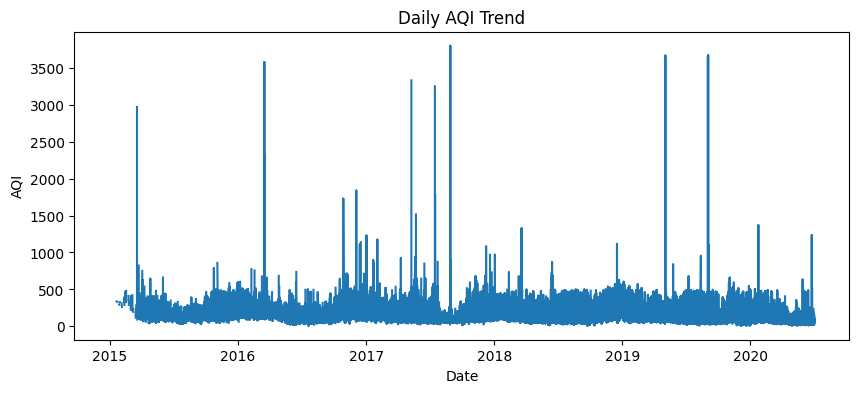

In [114]:
plt.figure(figsize=(10,4))
plt.plot(data['Date'], data['AQI'])
plt.title("Daily AQI Trend")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

In [115]:
corr_ = data[["AQI","PM2.5","PM10"]]

In [116]:
corr_matrix = corr_.corr(method='pearson')
print(corr_matrix)

            AQI     PM2.5      PM10
AQI    1.000000  0.807673  0.801796
PM2.5  0.807673  1.000000  0.846596
PM10   0.801796  0.846596  1.000000


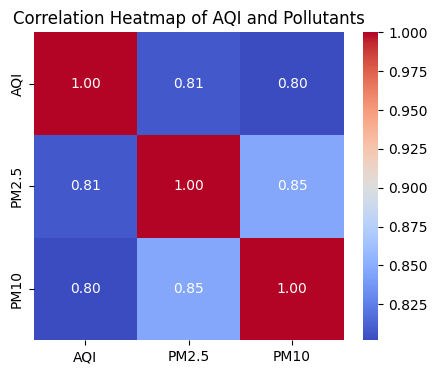

In [117]:
plt.figure(figsize=(5,4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Heatmap of AQI and Pollutants")
plt.show()

In [118]:
def get_health_factor(profile="healthy"):
    profiles = {
        "healthy": 0.3,
        "mild": 0.6,
        "severe": 0.9
    }
    if profile not in profiles:
        raise ValueError("Invalid health profile")
    return profiles[profile]


def weight_function(aqi):
    if aqi > 300:
        return 1.5
    elif aqi > 200:
        return 1.3
    elif aqi > 100:
        return 1.0
    else:
        return 0.7


DELTA_T = 1  # 1 day

def compute_risk(df, health_profile="healthy", exposure_days=None):
    h = get_health_factor(health_profile)

    if exposure_days is None:
        exposure_days = len(df)

    cumulative_exposure = 0.0

    for aqi in df['AQI'].iloc[:exposure_days]:
        print(aqi)
        cumulative_exposure += aqi * weight_function(aqi) * DELTA_T
    
    return h * cumulative_exposure


def normalize_risk(risk, min_risk, max_risk):
    if max_risk == min_risk:
        return 0.0
    return ((risk - min_risk) / (max_risk - min_risk)) * 100


def risk_decision(risk_norm):
    if risk_norm < 30:
        return "Safe"
    elif risk_norm < 60:
        return "Caution"
    else:
        return "Danger"

def compute_risk_bounds(df, health_profile="healthy"):
    h = get_health_factor(health_profile)
    cumulative_exposure = 0.0
    risks = []

    for aqi in df['AQI']:
        cumulative_exposure += aqi * weight_function(aqi) * DELTA_T
        risks.append(h * cumulative_exposure)

    return min(risks), max(risks)

def max_safe_exposure(df, health_profile="healthy", risk_limit=5000):
    h = get_health_factor(health_profile)
    cumulative_exposure = 0.0

    for i, aqi in enumerate(df['AQI']):
        cumulative_exposure += aqi * weight_function(aqi) * DELTA_T
        if h * cumulative_exposure > risk_limit:
            return i  # max safe days

    return len(df)



def predict_future_aqi(model, df, feature_names, days=7):
    history = df['AQI'].tolist()

    # Use last known pollutant values
    last_pm25 = df['PM2.5'].iloc[-1]
    last_pm10 = df['PM10'].iloc[-1]

    predictions = []

    for _ in range(days):
        row = {}

        for fname in feature_names:
            if fname == 'PM2.5':
                row[fname] = last_pm25
            elif fname == 'PM10':
                row[fname] = last_pm10
            else:
                lag = int(fname.split('_')[-1])
                row[fname] = history[-lag]

        X_future = pd.DataFrame([row])
        pred = model.predict(X_future)[0]

        predictions.append(pred)
        history.append(pred)

    return predictions


In [119]:
'''# df must be cleaned and sorted by Date
health_profile = "severe"

# Compute total risk
risk = compute_risk(data, health_profile)

# Compute normalization bounds
min_risk, max_risk = compute_risk_bounds(data, health_profile)

# Normalize risk
risk_norm = normalize_risk(risk, min_risk, max_risk)

# Decision
decision = risk_decision(risk_norm)

print("Raw Risk:", round(risk, 2))
print("Normalized Risk:", round(risk_norm, 2))
print("Decision:", decision)

# Optimization
safe_days = max_safe_exposure(data, health_profile, risk_limit=5000)
print("Max Safe Exposure Days:", safe_days)'''


'# df must be cleaned and sorted by Date\nhealth_profile = "severe"\n\n# Compute total risk\nrisk = compute_risk(data, health_profile)\n\n# Compute normalization bounds\nmin_risk, max_risk = compute_risk_bounds(data, health_profile)\n\n# Normalize risk\nrisk_norm = normalize_risk(risk, min_risk, max_risk)\n\n# Decision\ndecision = risk_decision(risk_norm)\n\nprint("Raw Risk:", round(risk, 2))\nprint("Normalized Risk:", round(risk_norm, 2))\nprint("Decision:", decision)\n\n# Optimization\nsafe_days = max_safe_exposure(data, health_profile, risk_limit=5000)\nprint("Max Safe Exposure Days:", safe_days)'

In [120]:
def create_lag_features(df, lags=[1, 2, 3, 7]):
    data = df.copy()
    for lag in lags:
        data[f'AQI_lag_{lag}'] = data['AQI'].shift(lag)
    data = data.dropna().reset_index(drop=True)
    return data


In [121]:
d = create_lag_features(data)

X = d.drop(columns=['Date', 'AQI','City'])
y = d['AQI']

split = int(0.8 * len(d))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [122]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [123]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

MAE: 24.95
RMSE: 42.81


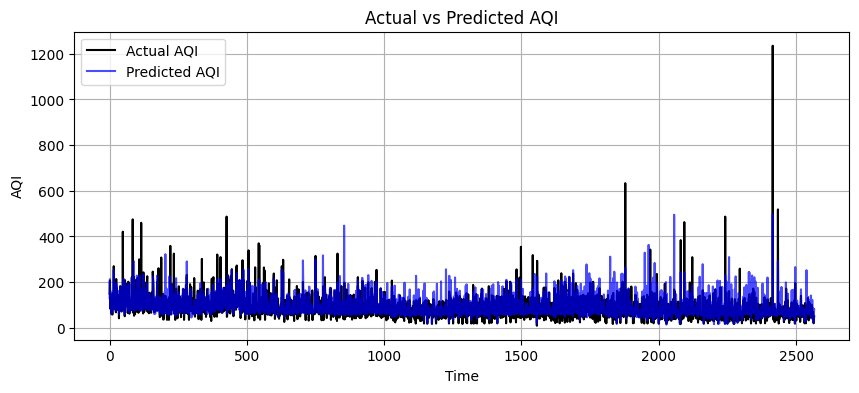

In [124]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="Actual AQI", color="black")
plt.plot(y_pred, label="Predicted AQI", color="blue", alpha=0.7)
plt.title("Actual vs Predicted AQI")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

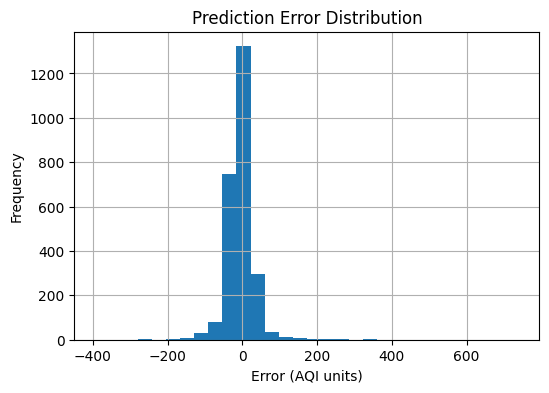

In [125]:
errors = y_test.values - y_pred

plt.figure(figsize=(6,4))
plt.hist(errors, bins=30)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (AQI units)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [126]:
# After ML prediction
future_aqi = predict_future_aqi(
    model,
    data,
    feature_names=feature_names,
    days=7
)

# Create export dictionary (SINGLE CITY)
predicted_aqi = {
    "Delhi": float(np.mean(future_aqi))
}

# Export to JSON
import json
with open("predicted_aqi.json","w") as f:
    json.dump(predicted_aqi, f, indent=2)

predicted_aqi


{'Delhi': 70.2139746343784}

In [127]:
feature_names = X.columns.tolist()
feature_names


['PM2.5', 'PM10', 'AQI_lag_1', 'AQI_lag_2', 'AQI_lag_3', 'AQI_lag_7']

In [128]:
future_aqi = predict_future_aqi(
    model,
    data,              # <-- correct dataframe
    feature_names,
    days=7
)

future_aqi


[np.float64(78.49472611977191),
 np.float64(70.300663713497),
 np.float64(67.78330920612122),
 np.float64(68.62262892151102),
 np.float64(68.00646751158642),
 np.float64(70.12040636841287),
 np.float64(68.16962059974836)]

In [129]:
predicted_aqi = {
    "Kochi": float(np.mean(future_aqi))
}

predicted_aqi


{'Kochi': 70.2139746343784}

In [130]:
with open("predicted_aqi.json", "w") as f:
    json.dump(predicted_aqi, f, indent=2)
